## **0. [H&M Personalized Fashion Recommendations - Kaggle Competition](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data)**

*Informacje z Kaggle:* 

- **Description** 

H&M Group is a family of brands and businesses with 53 online markets and approximately 4,850 stores. Our online store offers shoppers an extensive selection of products to browse through. But with too many choices, customers might not quickly find what interests them or what they are looking for, and ultimately, they might not make a purchase. To enhance the shopping experience, product recommendations are key. More importantly, helping customers make the right choices also has a positive implications for sustainability, as it reduces returns, and thereby minimizes emissions from transportation.

In this competition, H&M Group invites you to develop product recommendations based on data from previous transactions, as well as from customer and product meta data. The available meta data spans from simple data, such as garment type and customer age, to text data from product descriptions, to image data from garment images.

There are no preconceptions on what information that may be useful – that is for you to find out. If you want to investigate a categorical data type algorithm, or dive into NLP and image processing deep learning, that is up to you.

- **Evaluation**

Submissions are evaluated according to the Mean Average Precision @ 12 (MAP@12):

$$
MAP@12 = \frac{1}{U} \sum_{u=1}^{U} \frac{1}{\min(m, 12)} \sum_{k=1}^{\min(n, 12)} P(k) \times rel(k)
$$


where 𝑈 is the number of customers, 𝑃(𝑘) is the precision at cutoff 𝑘, 𝑛 is the number predictions per customer, 𝑚 is the number of ground truth values per customer, and 𝑟𝑒𝑙(𝑘) is an indicator function equaling 1 if the item at rank 𝑘 is a relevant (correct) label, zero otherwise.

Notes:

You will be making purchase predictions for all customer_id values provided, regardless of whether these customers made purchases in the training data.
Customer that did not make any purchase during test period are excluded from the scoring.
There is never a penalty for using the full 12 predictions for a customer that ordered fewer than 12 items; thus, it's advantageous to make 12 predictions for each customer.

- **Submission File**

For each customer_id observed in the training data, you may predict up to 12 labels for the article_id, which is the predicted items a customer will buy in the next 7-day period after the training time period. The file should contain a header and have the following format:

| customer_id | prediction                      |
|-------------|---------------------------------|
| 00000dba    | 0706016001 0706016002 0372860001 ... |
| 0000423b    | 0706016001 0706016002 0372860001 ... |
| ...         | ...                             |


## **1. Dataset Description**

For this challenge you are given the purchase history of customers across time, along with supporting metadata. Your challenge is to predict what articles each customer will purchase in the 7-day period immediately after the training data ends. Customer who did not make any purchase during that time are excluded from the scoring.

**Files:**

- images/ - a folder of images corresponding to each article_id; images are placed in subfolders starting with the first three digits of the article_id; note, not all article_id values have a corresponding image.
- articles.csv - detailed metadata for each article_id available for purchase
- customers.csv - metadata for each customer_id in dataset
- sample_submission.csv - a sample submission file in the correct format
- transactions_train.csv - the training data, consisting of the purchases each customer for each date, as well as additional information. Duplicate rows correspond to multiple purchases of the same item. Your task is to predict the article_ids each customer will purchase during the 7-day period immediately after the training data period.

NOTE: You must make predictions for all customer_id values found in the sample submission. All customers who made purchases during the test period are scored, regardless of whether they had purchase history in the training data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')

In [51]:
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
relations = pl.read_csv(".data/transactions_train.csv", try_parse_dates=True)
users = pl.read_csv(".data/customers.csv")
items = pl.read_csv(".data/articles.csv")
sample_submission = pl.read_csv(".data/sample_submission.csv")

In [8]:
relations

t_dat,customer_id,article_id,price,sales_channel_id
date,str,i64,f64,i64
2018-09-20,"""000058a12d5b43e67d225668fa1f8d…",663713001,0.050831,2
2018-09-20,"""000058a12d5b43e67d225668fa1f8d…",541518023,0.030492,2
2018-09-20,"""00007d2de826758b65a93dd24ce629…",505221004,0.015237,2
2018-09-20,"""00007d2de826758b65a93dd24ce629…",685687003,0.016932,2
2018-09-20,"""00007d2de826758b65a93dd24ce629…",685687004,0.016932,2
…,…,…,…,…
2020-09-22,"""fff2282977442e327b45d8c89afde2…",929511001,0.059305,2
2020-09-22,"""fff2282977442e327b45d8c89afde2…",891322004,0.042356,2
2020-09-22,"""fff380805474b287b05cb2a7507b9a…",918325001,0.043203,1


In [5]:
users

customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
str,f64,f64,str,str,i64,str
"""00000dbacae5abe5e23885899a1fa4…",null,null,"""ACTIVE""","""NONE""",49,"""52043ee2162cf5aa7ee79974281641…"
"""0000423b00ade91418cceaf3b26c6a…",null,null,"""ACTIVE""","""NONE""",25,"""2973abc54daa8a5f8ccfe9362140c6…"
"""000058a12d5b43e67d225668fa1f8d…",null,null,"""ACTIVE""","""NONE""",24,"""64f17e6a330a85798e4998f62d0930…"
"""00005ca1c9ed5f5146b52ac8639a40…",null,null,"""ACTIVE""","""NONE""",54,"""5d36574f52495e81f019b680c843c4…"
"""00006413d8573cd20ed7128e53b7b1…",1.0,1.0,"""ACTIVE""","""Regularly""",52,"""25fa5ddee9aac01b35208d01736e57…"
…,…,…,…,…,…,…
"""ffffbbf78b6eaac697a8a5dfbfd2bf…",null,null,"""ACTIVE""","""NONE""",24,"""7aa399f7e669990daba2d92c577b52…"
"""ffffcd5046a6143d29a04fb8c424ce…",null,null,"""ACTIVE""","""NONE""",21,"""3f47f1279beb72215f4de557d950e0…"
"""ffffcf35913a0bee60e8741cb2b4e7…",1.0,1.0,"""ACTIVE""","""Regularly""",21,"""4563fc79215672cd6a863f2b4bf56b…"


In [13]:
items

article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
i64,i64,str,i64,str,str,i64,str,i64,str,i64,str,i64,str,i64,str,str,str,i64,str,i64,str,i64,str,str
108775015,108775,"""Strap top""",253,"""Vest top""","""Garment Upper body""",1010016,"""Solid""",9,"""Black""",4,"""Dark""",5,"""Black""",1676,"""Jersey Basic""","""A""","""Ladieswear""",1,"""Ladieswear""",16,"""Womens Everyday Basics""",1002,"""Jersey Basic""","""Jersey top with narrow shoulde…"
108775044,108775,"""Strap top""",253,"""Vest top""","""Garment Upper body""",1010016,"""Solid""",10,"""White""",3,"""Light""",9,"""White""",1676,"""Jersey Basic""","""A""","""Ladieswear""",1,"""Ladieswear""",16,"""Womens Everyday Basics""",1002,"""Jersey Basic""","""Jersey top with narrow shoulde…"
108775051,108775,"""Strap top (1)""",253,"""Vest top""","""Garment Upper body""",1010017,"""Stripe""",11,"""Off White""",1,"""Dusty Light""",9,"""White""",1676,"""Jersey Basic""","""A""","""Ladieswear""",1,"""Ladieswear""",16,"""Womens Everyday Basics""",1002,"""Jersey Basic""","""Jersey top with narrow shoulde…"
110065001,110065,"""OP T-shirt (Idro)""",306,"""Bra""","""Underwear""",1010016,"""Solid""",9,"""Black""",4,"""Dark""",5,"""Black""",1339,"""Clean Lingerie""","""B""","""Lingeries/Tights""",1,"""Ladieswear""",61,"""Womens Lingerie""",1017,"""Under-, Nightwear""","""Microfibre T-shirt bra with un…"
110065002,110065,"""OP T-shirt (Idro)""",306,"""Bra""","""Underwear""",1010016,"""Solid""",10,"""White""",3,"""Light""",9,"""White""",1339,"""Clean Lingerie""","""B""","""Lingeries/Tights""",1,"""Ladieswear""",61,"""Womens Lingerie""",1017,"""Under-, Nightwear""","""Microfibre T-shirt bra with un…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
953450001,953450,"""5pk regular Placement1""",302,"""Socks""","""Socks & Tights""",1010014,"""Placement print""",9,"""Black""",4,"""Dark""",5,"""Black""",7188,"""Socks Bin""","""F""","""Menswear""",3,"""Menswear""",26,"""Men Underwear""",1021,"""Socks and Tights""","""Socks in a fine-knit cotton bl…"
953763001,953763,"""SPORT Malaga tank""",253,"""Vest top""","""Garment Upper body""",1010016,"""Solid""",9,"""Black""",4,"""Dark""",5,"""Black""",1919,"""Jersey""","""A""","""Ladieswear""",1,"""Ladieswear""",2,"""H&M+""",1005,"""Jersey Fancy""","""Loose-fitting sports vest top …"
956217002,956217,"""Cartwheel dress""",265,"""Dress""","""Garment Full body""",1010016,"""Solid""",9,"""Black""",4,"""Dark""",5,"""Black""",1641,"""Jersey""","""A""","""Ladieswear""",1,"""Ladieswear""",18,"""Womens Trend""",1005,"""Jersey Fancy""","""Short, A-line dress in jersey …"


In [9]:
sample_submission

customer_id,prediction
str,str
"""00000dbacae5abe5e23885899a1fa4…","""0706016001 0706016002 03728600…"
"""0000423b00ade91418cceaf3b26c6a…","""0706016001 0706016002 03728600…"
"""000058a12d5b43e67d225668fa1f8d…","""0706016001 0706016002 03728600…"
"""00005ca1c9ed5f5146b52ac8639a40…","""0706016001 0706016002 03728600…"
"""00006413d8573cd20ed7128e53b7b1…","""0706016001 0706016002 03728600…"
…,…
"""ffffbbf78b6eaac697a8a5dfbfd2bf…","""0706016001 0706016002 03728600…"
"""ffffcd5046a6143d29a04fb8c424ce…","""0706016001 0706016002 03728600…"
"""ffffcf35913a0bee60e8741cb2b4e7…","""0706016001 0706016002 03728600…"


# **2.**

In [52]:
train_valid_customers = relations.select(pl.col("customer_id")).unique().to_series().to_numpy()
test_cusomers = sample_submission.select("customer_id").unique().to_series().to_numpy()

np.setdiff1d(test_cusomers, train_valid_customers)

KeyboardInterrupt: 

shape: (734, 2)
┌────────────┬───────┐
│ t_dat      ┆ count │
│ ---        ┆ ---   │
│ date       ┆ u32   │
╞════════════╪═══════╡
│ 2018-09-20 ┆ 48399 │
│ 2018-09-21 ┆ 47543 │
│ 2018-09-22 ┆ 17635 │
│ 2018-09-23 ┆ 52230 │
│ 2018-09-24 ┆ 45984 │
│ …          ┆ …     │
│ 2020-09-18 ┆ 39284 │
│ 2020-09-19 ┆ 36796 │
│ 2020-09-20 ┆ 31489 │
│ 2020-09-21 ┆ 32130 │
│ 2020-09-22 ┆ 32866 │
└────────────┴───────┘


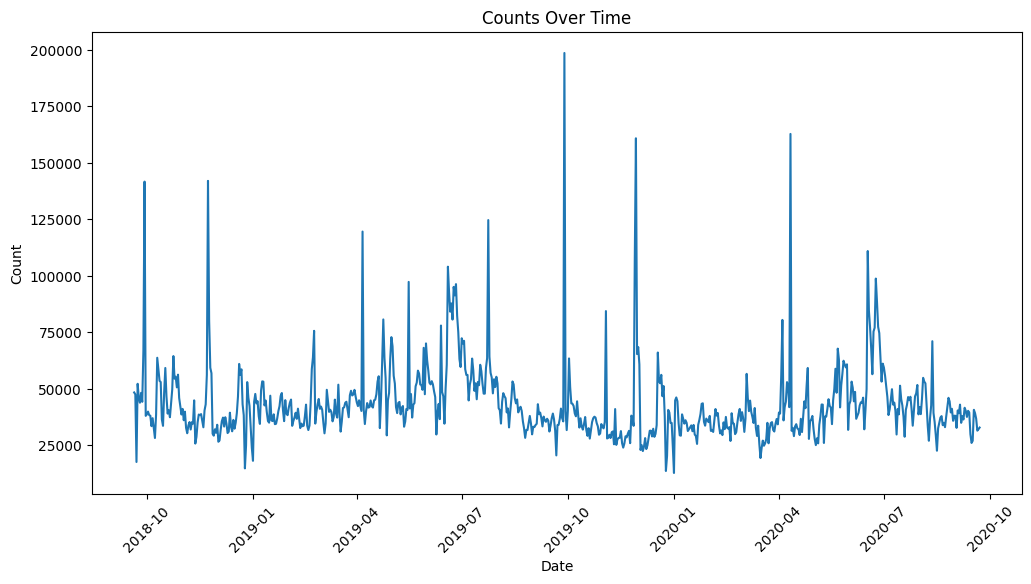

In [15]:
counts = relations.group_by("t_dat", maintain_order=True).agg(pl.len().alias("count"))
print(counts)
plt.figure(figsize=(12, 6))
sns.lineplot(data=counts.to_pandas(), x='t_dat', y='count')
plt.title('Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()